# Linear State-Space Models

Provided are two examples of linear state-space models on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1] and [2].

We provide examples for two different types of state-space model:
1. [Linear, Discrete State-Space Model](#1.-Linear-Discrete-State-Space-Model:-Car-Tracking): Car Tracking
2. [Linear, Continuous-Discrete State-Space Model](#2.-Linear-Continuous-Discrete-State-Space-Model:-Ornstein-Uhlenbeck-Process): The Ornstein-Uhlenbeck Process


**References**:
> [1] Särkkä, Simo, and Solin, Arno. Applied Stochastic Differential Equations. Cambridge University Press, 2019.  
>
> [2] Särkkä, Simo. Bayesian Filtering and Smoothing. Cambridge University Press, 2013.

In [1]:
import numpy as np

import probnum as pn
import probnum.filtsmooth as pnfs
import probnum.random_variables as pnrv

In [2]:
np.random.seed(12345)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../../probnum.mplstyle')

## 1. **Linear Discrete** State-Space Model: Car Tracking

---

We begin showcasing the arguably most simple case in which we consider the following state-space model. Consider matrices $A \in \mathbb{R}^{d \times d}$ and $H \in \mathbb{R}^{m \times d}$ where $d$ is the state dimension and $m$ is the dimension of the measurements. Then we define the dynamics and the measurement model as follows:

For $k = 1, \dots, K$ and $x_0 \sim \mathcal{N}(\mu_0, \Sigma_0)$:

$$
\begin{align}
    \boldsymbol{x}_k &\sim \mathcal{N}(\boldsymbol{A} \, \boldsymbol{x}_{k-1}, \boldsymbol{Q}) \\
    \boldsymbol{y}_k &\sim \mathcal{N}(\boldsymbol{H} \, \boldsymbol{x}_k, \boldsymbol{R})
\end{align}
$$

This defines a dynamics model that assumes a state $\boldsymbol{x}_k$ in a **discrete** sequence of states arising from a linear projection of the previous state $x_{k-1}$ corrupted with additive Gaussian noise under a **process noise** covariance matrix $Q$.  
Similarly, the measurements $\boldsymbol{y}_k$ are assumed to be linear projections of the latent state under additive Gaussian noise according to a **measurement noise** covariance $R$.
In the following example we consider projections and covariances that are constant over the state and measurement trajectories (linear time invariant, or **LTI**). Note that this can be generalized to a linear time-varying state-space model, as well. Then $A$ is a function $A: \mathbb{T} \rightarrow \mathbb{R}^{d \times d}$ and $H$ is a function $H: \mathbb{T} \rightarrow \mathbb{R}^{m \times d}$ where $\mathbb{T}$ is the "time dimension".

In other words, here, every relationship is linear and every distribution is a Gaussian distribution.
Under these simplifying assumptions it is possible to obtain a filtering posterior distribution over the state trajectory $(\boldsymbol{x}_k)_{k=1}^{K}$ by using a 
**Kalman Filter**. The example is taken from Example 3.6 in [2].

### Define State-Space Model

#### I. Discrete Dynamics Model: Linear, Time-Invariant, Gaussian Transitions

In [4]:
state_dim = 4
observation_dim = 2

In [5]:
delta_t = 0.2
# Define linear transition operator
dynamics_transition_matrix = np.eye(state_dim) + delta_t * np.diag(np.ones(2), 2)
# Define process noise (covariance) matrix
process_noise_matrix = (
    np.diag(np.array([delta_t ** 3 / 3, delta_t ** 3 / 3, delta_t, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), 2)
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), -2)
)

To create a discrete, LTI Gaussian dynamics model, `probnum` provides the `DiscreteLTIGaussian` class that takes
- `state_trans_mat` : the linear transition matrix (above: $A$)
- `shift_vec` : a force vector for _affine_ transformations of the state (here: zero)
- `proc_noise_cov_mat` : the covariance matrix for the Gaussian process noise

In [6]:
# Create discrete, Linear Time-Invariant Gaussian dynamics model
dynamics_model = pnfs.statespace.DiscreteLTIGaussian(
    state_trans_mat=dynamics_transition_matrix,
    shift_vec=np.zeros(state_dim),
    proc_noise_cov_mat=process_noise_matrix,
)

#### II. Discrete Measurement Model: Linear, Time-Invariant, Gaussian Measurements

In [7]:
measurement_marginal_variance = 0.5
measurement_matrix = np.eye(observation_dim, state_dim)
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [8]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    state_trans_mat=measurement_matrix,
    shift_vec=np.zeros(observation_dim),
    proc_noise_cov_mat=measurement_noise_matrix,
)

#### III. Initial State Random Variable

In [9]:
mu_0 = np.zeros(state_dim)
sigma_0 = 0.5 * measurement_marginal_variance * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

### Generate Data for the State-Space Model

`statespace.generate_samples()` is used to sample both latent states and noisy observations from the specified state space model.

In [10]:
time_grid = np.arange(0., 20., step=delta_t)

In [11]:
latent_states, observations = pnfs.statespace.generate_samples(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid,
)

### Kalman Filtering

#### I. Kalman Filter

In [12]:
kalman_filter = pnfs.Kalman(
    dynamics_model=dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

#### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [13]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and interpolation.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [14]:
posterior_state_rvs = state_posterior.state_rvs       # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov        # Shape: (num_time_points, state_dim, state_dim)

### Visualize Results

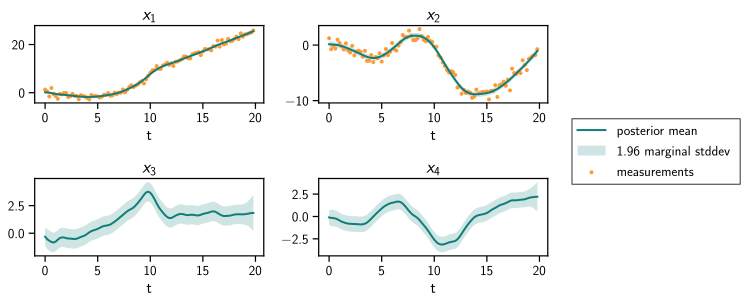

In [15]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=2, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])
ax_10 = state_fig.add_subplot(state_fig_gs[1, 0])
ax_11 = state_fig.add_subplot(state_fig_gs[1, 1])

# Plot means
mu_x_1, mu_x_2, mu_x_3, mu_x_4 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1, label="posterior mean");
ax_01.plot(time_grid, mu_x_2);
ax_10.plot(time_grid, mu_x_3);
ax_11.plot(time_grid, mu_x_4);

# Plot marginal standard deviations
std_x_1, std_x_2, std_x_3, std_x_4 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(time_grid, mu_x_1 - 1.96 * std_x_1,  mu_x_1 + 1.96 * std_x_1, alpha=0.2, label="1.96 marginal stddev");
ax_01.fill_between(time_grid, mu_x_2 - 1.96 * std_x_2,  mu_x_2 + 1.96 * std_x_2, alpha=0.2);
ax_10.fill_between(time_grid, mu_x_3 - 1.96 * std_x_3,  mu_x_3 + 1.96 * std_x_3, alpha=0.2);
ax_11.fill_between(time_grid, mu_x_4 - 1.96 * std_x_4,  mu_x_4 + 1.96 * std_x_4, alpha=0.2);

# Plot groundtruth
obs_x_1, obs_x_2 = [observations[:, i] for i in range(observation_dim)]

ax_00.scatter(time_grid, obs_x_1, marker=".", label="measurements");
ax_01.scatter(time_grid, obs_x_2, marker=".");

# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")
ax_10.set_xlabel("t")
ax_11.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")
ax_10.set_title(r"$x_3$")
ax_11.set_title(r"$x_4$")
handles, labels = ax_00.get_legend_handles_labels()
state_fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

state_fig.tight_layout()

## 2. **Linear Continuous-Discrete** State-Space Model: Ornstein-Uhlenbeck Process

---

Now, consider we have a look at **continuous** dynamics. We assume that there is a continuous process that defines the dynamics of our latent space from which we collect discrete linear-Gaussian measurements (as above). Only the dynamics model becomes continuous. In particular, we formulate the dynamics as a stochastic process in terms of a linear time-invariant stochastic differential equation (LTISDE). We refer to [1] for more details.
Consider matrices $\boldsymbol{F} \in \mathbb{R}^{d \times d}$, $\boldsymbol{L} \in \mathbb{R}^{s \times d}$ and $H \in \mathbb{R}^{m \times d}$ where $d$ is the state dimension and $m$ is the dimension of the measurements.
We define the following **continuous-discrete** state-space model:

Let $x(t_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$.

$$
\begin{align}
    d\boldsymbol{x} &= \boldsymbol{F} \, \boldsymbol{x} \, dt + \boldsymbol{L} \, d \boldsymbol{\omega} \\
    \boldsymbol{y}_k &\sim \mathcal{N}(\boldsymbol{H} \, \boldsymbol{x}(t_k), \boldsymbol{R}), \qquad k = 1, \dots, K
\end{align}
$$

where $\boldsymbol{\omega} \in \mathbb{R}^s$ denotes a vector of driving forces (often Brownian Motion).

Note that this can be generalized to a linear time-varying state-space model, as well. Then $\boldsymbol{F}$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{d \times d}$,
$\boldsymbol{L}$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{s \times d}$, and $H$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{m \times d}$ where $\mathbb{T}$ is the "time dimension". In the following example, however, we consider a LTI SDE, namely, the Ornstein-Uhlenbeck Process from which we observe discrete linear Gaussian measurements.

### Define State-Space Model

#### I. Continuous Dynamics Model: Linear, Time-Invariant Stochastic Differential Equation (LTISDE)

In [16]:
state_dim = 1
observation_dim = 1

In [17]:
delta_t = 0.2
# Define Linear, time-invariant Stochastic Differential Equation that models
# the (scalar) Ornstein-Uhlenbeck Process
drift_constant = 0.21
dispersion_constant = np.sqrt(0.5)
drift = -drift_constant * np.eye(state_dim)
force = np.zeros(state_dim)
dispersion = dispersion_constant * np.eye(state_dim)

The _continuous_ counterpart to the discrete LTI Gaussian model from above is provided via the `LTISDE` class.
It is initialized by the state space components
- `driftmat` : the drift matrix $\boldsymbol{F}$
- `forcevec` : a force vector that is added to the state (note that this is **not** $\boldsymbol{\omega}$.) Here: zero.
- `dispmat` : the dispersion matrix $\boldsymbol{L}$

In [18]:
# Create dynamics model
dynamics_model = pnfs.statespace.LTISDE(
    driftmat=drift, 
    forcevec=force,
    dispmat=dispersion,
)

#### II. Discrete Measurement Model: Linear, Time-Invariant Gaussian Measurements

In [19]:
measurement_marginal_variance = 0.1
measurement_matrix = np.eye(observation_dim, state_dim)
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

As above, the measurement model is discrete, LTI Gaussian. Only the dymanics are continuous (i.e. continuous-discrete).

In [20]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    state_trans_mat=measurement_matrix,
    shift_vec=np.zeros(observation_dim),
    proc_noise_cov_mat=measurement_noise_matrix,
)

#### III. Initial State Random Variable

In [21]:
mu_0 = 10. * np.ones(state_dim)
sigma_0 = np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

### Generate Data for the State-Space Model

`statespace.generate_samples()` is used to sample both latent states and noisy observations from the specified state space model.

In [22]:
time_grid = np.arange(0., 20., step=delta_t)

In [23]:
latent_states, observations = pnfs.statespace.generate_samples(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid,
)

### Kalman Filtering

In fact, since we still consider a **linear** model, we can apply Kalman Filtering in this case again.
According to Section 10 in [1], the moments of the filtering posterior in the continuous-discrete case are solutions to linear differential equations, which `probnum` solves for us when invoking the `<Kalman_object>.filtsmooth(...)` method.

#### I. Kalman Filter

In [24]:
kalman_filter = pnfs.Kalman(
    dynamics_model=dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv,
)

#### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [25]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [26]:
posterior_state_rvs = state_posterior.state_rvs             # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean.squeeze()  # Shape: (num_time_points, )
posterior_state_covs = posterior_state_rvs.cov              # Shape: (num_time_points, )

### Visualize Results

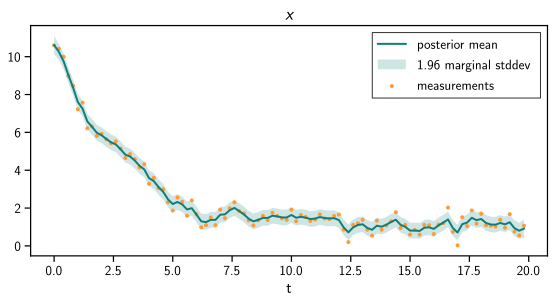

In [27]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(time_grid, posterior_state_means, label="posterior mean")

# Plot marginal standard deviations
std_x = np.sqrt(posterior_state_covs).squeeze()
ax.fill_between(
    time_grid,
    posterior_state_means - 1.96 * std_x,
    posterior_state_means + 1.96 * std_x,
    alpha=0.2,
    label="1.96 marginal stddev",
)
ax.scatter(time_grid, observations, marker=".", label="measurements")

# Add labels etc.
ax.set_xlabel("t")
ax.set_title(r"$x$")
ax.legend()

state_fig.tight_layout()